# Imports

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
from itertools import product

# Config

In [2]:
DATA_FILE_PATHS = '/workspace/rahnemacollege/Project/Git/demand-prediction/data'
SHAPE_FILE_PATH = '/workspace/rahnemacollege/Project/Git/demand-prediction/map_data/taxi_zones/taxi_zones.shp'
start_date = '2023-03-31'
end_date = '2023-05-01'

# Load Data files

In [3]:
def load_data(file_paths, start_date=None):
    df = pd.read_parquet(file_paths)
    df['date'] = df['tpep_pickup_datetime'].dt.date.astype(str)

    if start_date:
        df = df[df['date'] > start_date].reset_index(drop=True)

    return df


rides_df = load_data(DATA_FILE_PATHS, start_date)
print(rides_df.shape)
rides_df.head()

(3288286, 20)


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,date
0,2,2023-04-03 11:25:19,2023-04-03 11:48:59,1.0,7.89,1.0,N,138,116,1,35.2,6.0,0.5,8.58,6.55,1.0,59.08,0.0,NaN,2023-04-03
1,2,2023-04-03 12:03:26,2023-04-03 12:08:57,2.0,0.89,1.0,N,151,239,1,7.9,1.0,0.5,1.00,0.00,1.0,13.90,2.5,NaN,2023-04-03
2,2,2023-04-03 12:44:48,2023-04-03 12:54:01,1.0,1.27,1.0,N,143,237,1,10.7,1.0,0.5,3.14,0.00,1.0,18.84,2.5,NaN,2023-04-03
3,2,2023-04-03 13:48:39,2023-04-03 14:04:47,1.0,2.00,1.0,N,186,79,1,16.3,1.0,0.5,4.26,0.00,1.0,25.56,2.5,NaN,2023-04-03
4,2,2023-04-03 14:07:39,2023-04-03 14:28:56,2.0,2.64,1.0,N,107,230,2,20.5,1.0,0.5,0.00,0.00,1.0,25.50,2.5,NaN,2023-04-03


In [4]:
def labeling(rides_df: pd.DataFrame):
    aggregated_df = rides_df.groupby(
        ['date', 'PULocationID']).size().reset_index(name='count')
    unique_dates = rides_df['date'].unique()
    unique_pu_location_ids = rides_df['PULocationID'].unique()
    all_combinations = list(product(unique_dates, unique_pu_location_ids))
    combinations_df = pd.DataFrame(all_combinations, columns=[
                                   'date', 'PULocationID'])
    label_df = aggregated_df.merge(combinations_df, how='right', on=[
                                   'date', 'PULocationID']).fillna(0)
    return label_df


labels_df = labeling(rides_df)
print(labels_df.shape)
labels_df.head()

(8514, 3)


,date,PULocationID,count
0,2023-04-03,138,3818.0
1,2023-04-03,151,862.0
2,2023-04-03,143,1112.0
3,2023-04-03,186,3223.0
4,2023-04-03,107,1725.0


### Improved Data Bound Within Range: 2023-04-01 to 2023-04-30

For Model Evaluation

In [5]:
labels_df['date'] = pd.to_datetime(labels_df['date'])

In [6]:
filtered_rides_df = labels_df[(labels_df['date'] >= start_date) & (
    labels_df['date'] < end_date)]

In [7]:
# Sort the DataFrame based on the 'tpep_pickup_datetime' column in ascending order
filtered_rides_df = filtered_rides_df.sort_values(by='date')

In [8]:
filtered_rides_df = filtered_rides_df.reset_index(drop=True)

In [9]:
# Step 1: Generate random noise
noise = np.random.randint(0, 10, size=len(filtered_rides_df))

filtered_rides_df['pred_count'] = filtered_rides_df['count'] + noise

In [10]:
print(filtered_rides_df.shape)
filtered_rides_df.head()

(7740, 4)


,date,PULocationID,count,pred_count
0,2023-04-01,138,2275.0,2276.0
1,2023-04-01,29,2.0,3.0
2,2023-04-01,108,4.0,9.0
3,2023-04-01,35,3.0,10.0
4,2023-04-01,6,1.0,5.0


In [11]:
# To handle the issue with MAPE and zero values in the count column, we replace zeros
# with the minimum non-zero count value. This prevents division by zero and ensures
# accurate evaluation of the metric.
min_non_zero_value = np.min(
    filtered_rides_df['count'][filtered_rides_df['count'] != 0])
filtered_rides_df.loc[filtered_rides_df['count']
                      == 0, 'count'] = min_non_zero_value

# Report by MAPE Metric

### Define MAPE Metric Function

In [12]:
# Define the MAPE calculation function
def calculate_mape(actual, predicted):
    return (abs((actual - predicted) / actual)).mean() * 100


# Calculate MAPE
mape = calculate_mape(
    filtered_rides_df['count'], filtered_rides_df['pred_count'])
print("MAPE: {:.2f}%".format(mape))

MAPE: 138.56%


### Calculate MAPE per LocationID

In [13]:
def calculate_mape_locationID(df, Location_Col, LocationID):
    selected_df = df[df[Location_Col] == LocationID]
    actual = selected_df['count']
    predicted = selected_df['pred_count']
    mape = calculate_mape(actual, predicted)
    return mape

In [14]:
locationID_mape = 2
mape_LocationID_output = calculate_mape_locationID(
    filtered_rides_df, 'PULocationID', locationID_mape)
print("MAPE for LocationID {}: {:.2f}%".format(
    locationID_mape, mape_LocationID_output))

MAPE for LocationID 2: 416.67%


### Calculate Average MAPE per all LocationIDs

In [15]:
PULocationIDs = filtered_rides_df['PULocationID'].unique()
PULocationIDs.sort()
mape_all = []
for locationID in PULocationIDs:
    mape_location = calculate_mape_locationID(
        filtered_rides_df, 'PULocationID', locationID)
    mape_all.append({'LocationID': locationID, 'MAPE': mape_location})


PULocationIDs_MAPE = pd.DataFrame(mape_all)
print(PULocationIDs_MAPE.shape)
print(PULocationIDs_MAPE.head())


AvgMAPE = sum(PULocationIDs_MAPE['MAPE'].values)/len(PULocationIDs)
print("Average MAPE per LocationIDs: {:.2f}%".format(mape))

(258, 2)
   LocationID        MAPE
0           1   32.973359
1           2  416.666667
2           3  269.833333
3           4    4.348659
4           5  376.111111
Average MAPE per LocationIDs: 138.56%


## Visualization

### MAPE Metric on Map based on selected date

Zones (Borough): **EWR, Queens, Bronx, Manhattan, Staten Island, Brooklyn**

Date Range: **2023-04-01_2023-04-30**

In [16]:
# This function shows MAPE metric on map based on selected date on month
# Becuase of to many locationIDs, we limited our visualization to each zone(Borough)
def visualize_mape_zone_date(zone, date, df):
    shape = gpd.read_file(SHAPE_FILE_PATH)
    counts_PU = df.rename(columns={'PULocationID': 'LocationID'})
    counts_PU = counts_PU[counts_PU['date'] == date]
    merged_gdf = shape.merge(counts_PU, on='LocationID', how='left')
    merged_gdf = merged_gdf.dropna()
    merged_gdf['MAPE'] = np.where(merged_gdf['count'] != 0, (abs(
        (merged_gdf['count'] - merged_gdf['pred_count']) / merged_gdf['count'])) * 100, 1)
    merged_gdf_selected = merged_gdf[merged_gdf['borough'] == zone]

    # Create a single plot
    fig, ax = plt.subplots(figsize=(10, 7.5))

    # Plot the map with 'MAPE' column
    merged_gdf_selected.plot(
        column='MAPE', cmap='Oranges_r', legend=True, ax=ax)
    ax.set_title('Prediction based on MAPE for selected date: {}'.format(date))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Annotate 'MAPE' values on the map
    for idx, row in merged_gdf_selected.iterrows():
        loc_mape = "{}\n{:.1f}%".format(row['LocationID'], row['MAPE'])
        x, y = row.geometry.centroid.x, row.geometry.centroid.y
        ax.text(x, y, str(loc_mape), fontsize=8,
                ha='center', va='center', color='black')

    plt.show()

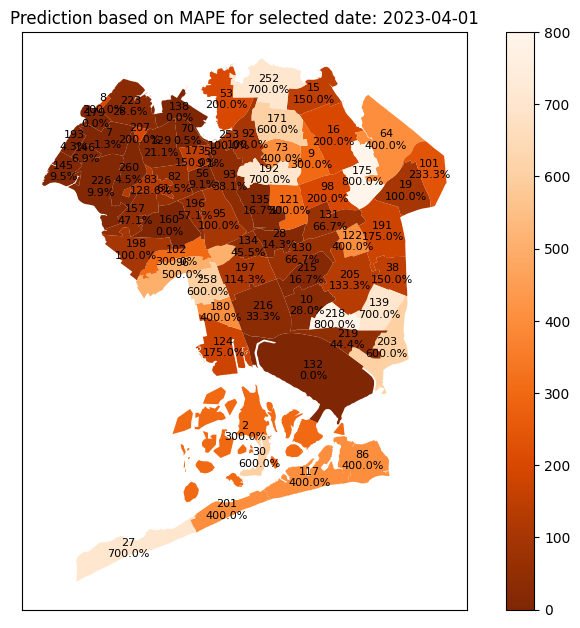

In [17]:
visualize_mape_zone_date('Queens', '2023-04-01', filtered_rides_df)

### MAPE Metric on Map based on whole test data

Zones (Borough): **EWR, Queens, Bronx, Manhattan, Staten Island, Brooklyn**


In [18]:
# This function shows MAPE metric on map based on whole test data
# Becuase of to many locationIDs, we limited our visualization to each zone(Borough)
def visualize_mape_zone(zone, df):
    shape = gpd.read_file(SHAPE_FILE_PATH)
    counts_PU = df.rename(
        columns={'PULocationID': 'LocationID'})
    merged_gdf = shape.merge(counts_PU, on='LocationID', how='left')
    merged_gdf = merged_gdf.dropna()
    merged_gdf_selected = merged_gdf[merged_gdf['borough'] == zone]

    # Create a single plot
    fig, ax = plt.subplots(figsize=(10, 7.5))

    # Plot the map with 'count' column
    # Reverse the colormap by setting vmin and vmax to reverse the values
    merged_gdf_selected.plot(
        column='MAPE', cmap='Oranges_r', legend=True, ax=ax)
    ax.set_title('Prediction based on MAPE for {}'.format(zone))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Annotate 'MAPE' values on the map
    for idx, row in merged_gdf_selected.iterrows():
        location_id = "{}\n{:.1f}%".format(row['LocationID'], row['MAPE'])
        x, y = row.geometry.centroid.x, row.geometry.centroid.y
        ax.text(x, y, str(location_id), fontsize=8,
                ha='center', va='center', color='black')

    plt.show()

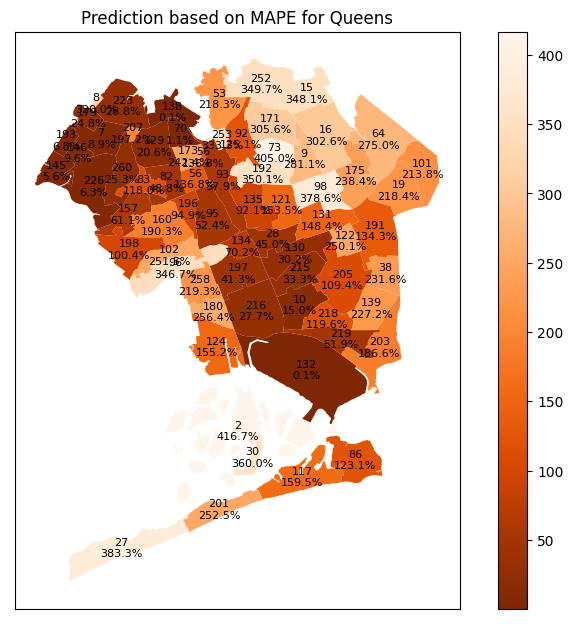

In [19]:
visualize_mape_zone('Queens', PULocationIDs_MAPE)